<a href="https://colab.research.google.com/github/nandana-krishna-13/FETAL-HEALTH-CLASSIFICATION-USING-DL/blob/main/DL_Project_Group_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Requirements**

In [ ]:
!pip install kagglehub pandas xlrd openpyxl


In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input, LSTM, Flatten, TimeDistributed, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
path = kagglehub.dataset_download("propanon/uci-cardiotocography")

print("Path to dataset files:", path)

100%|██████████| 356k/356k [00:00<00:00, 63.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/propanon/uci-cardiotocography/versions/1


## **Data Loader**

In [ ]:
file_path = "/root/.cache/kagglehub/datasets/propanon/uci-cardiotocography/versions/1/CTG.xls"

# Load the Excel file and get all sheet names
excel_file = pd.ExcelFile(file_path)
print("Sheet names:", excel_file.sheet_names)

# Read all sheets into a dictionary of DataFrames
dfs = {sheet: excel_file.parse(sheet) for sheet in excel_file.sheet_names}

df = dfs['Data']
df.head()

Sheet names: ['Description', 'Data', 'Raw Data']


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,22,Unnamed: 44,23
0,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1


In [ ]:
col_names = df.loc[0]
df.drop(0, axis=0, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,22,Unnamed: 44,23
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
5,533,1147,4,0,5,0,0,0,0,NaN,...,-1,-1,-1,-1,-1,-1,NaN,2,NaN,1


In [ ]:
df.columns = col_names

In [ ]:
df.columns

Index([       'b',        'e',       'AC',       'FM',       'UC',       'DL',
             'DS',       'DP',       'DR',        nan,       'LB',       'AC',
             'FM',       'UC',       'DL',       'DS',       'DP',     'ASTV',
           'MSTV',     'ALTV',     'MLTV',    'Width',      'Min',      'Max',
           'Nmax',   'Nzeros',     'Mode',     'Mean',   'Median', 'Variance',
       'Tendency',        nan,        'A',        'B',        'C',        'D',
              'E',       'AD',       'DE',       'LD',       'FS',     'SUSP',
              nan,    'CLASS',        nan,      'NSP'],
      dtype='object', name=0)

In [ ]:
df = df.loc[:, df.columns.notna()]

df.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,240,357,0,0,0,0,0,0,0,120,...,-1,-1,-1,-1,-1,-1,1,-1,9,2
2,5,632,4,0,4,2,0,0,0,132,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
3,177,779,2,0,5,2,0,0,0,133,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
4,411,1192,2,0,6,2,0,0,0,134,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
5,533,1147,4,0,5,0,0,0,0,132,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 1 to 2129
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   b         2126 non-null   object
 1   e         2126 non-null   object
 2   AC        2126 non-null   object
 3   FM        2127 non-null   object
 4   UC        2127 non-null   object
 5   DL        2128 non-null   object
 6   DS        2128 non-null   object
 7   DP        2128 non-null   object
 8   DR        2128 non-null   object
 9   LB        2126 non-null   object
 10  AC        2126 non-null   object
 11  FM        2127 non-null   object
 12  UC        2127 non-null   object
 13  DL        2128 non-null   object
 14  DS        2128 non-null   object
 15  DP        2128 non-null   object
 16  ASTV      2127 non-null   object
 17  MSTV      2127 non-null   object
 18  ALTV      2127 non-null   object
 19  MLTV      2127 non-null   object
 20  Width     2126 non-null   object
 21  Min       2126

In [ ]:
df.describe()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126,2126,2126,2127,2127,2128,2128,2128,2128,2126,...,2127,2127,2127,2127,2127,2127,2127,2127,2126,2126
unique,979,1064,22,96,19,15,2,5,1,48,...,3,3,3,3,3,3,3,3,10,3
top,0,1199,0,0,0,0,0,0,0,133,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1
freq,314,155,891,1311,332,1232,2120,1949,2128,136,...,2073,2045,2054,1794,1874,2019,2057,1929,579,1655


In [ ]:
df.isnull().sum()

,0
0,
b,3
e,3
AC,3
FM,2
UC,2
DL,1
DS,1
DP,1
DR,1


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df.isnull().sum()

<ipython-input-13-bbbf8c1d5b41>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-13-bbbf8c1d5b41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


,0
0,
b,0
e,0
AC,0
FM,0
UC,0
DL,0
DS,0
DP,0
DR,0


In [ ]:
df.shape

(2126, 42)

# **Explorative Data Analysis**

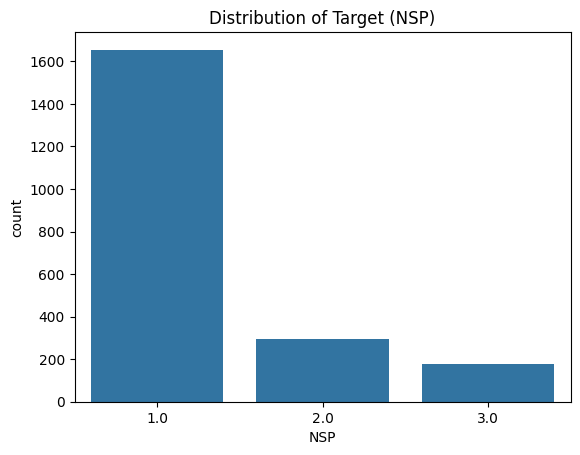

In [ ]:
sns.countplot(data=df, x='NSP')
plt.title("Distribution of Target (NSP)")
plt.show()

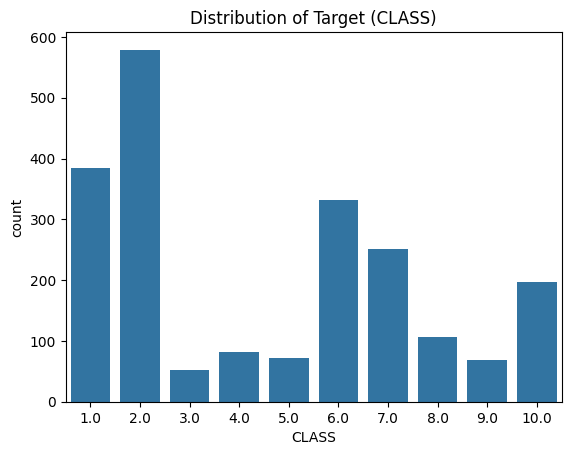

In [ ]:
sns.countplot(data=df, x='CLASS')
plt.title("Distribution of Target (CLASS)")
plt.show()

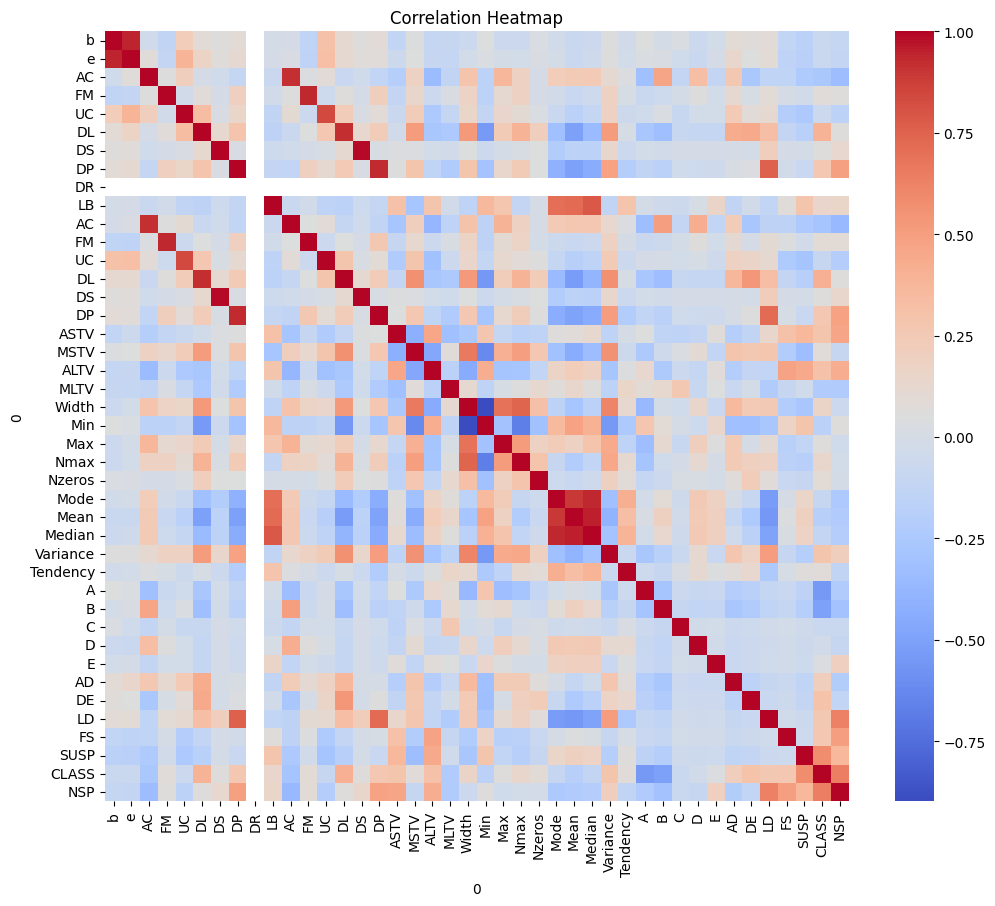

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
df.drop('DR', axis=1, inplace=True)

In [ ]:
df = df.loc[:, ~df.columns.duplicated()]

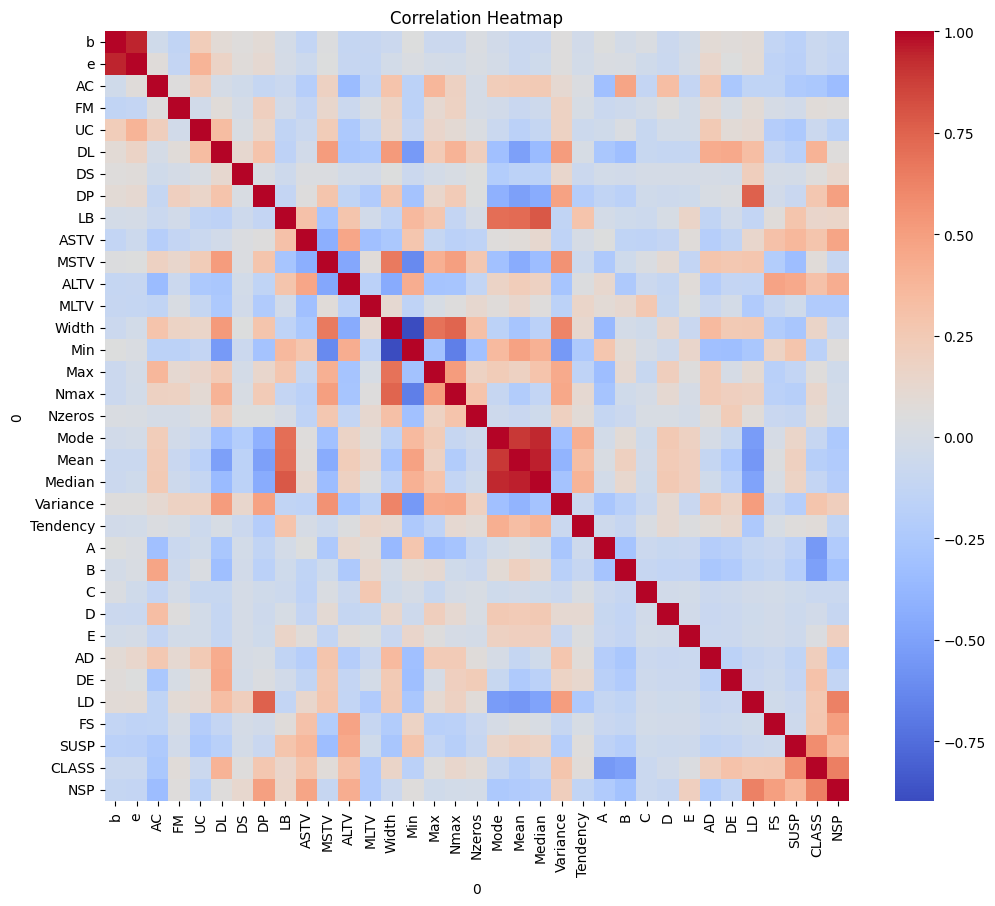

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# **Data Splitting**

In [ ]:
df['CLASS']

,CLASS
1,9.0
2,6.0
3,6.0
4,6.0
5,2.0
...,...
2122,5.0
2123,5.0
2124,5.0
2125,5.0


In [ ]:
df['NSP']

,NSP
1,2.0
2,1.0
3,1.0
4,1.0
5,1.0
...,...
2122,2.0
2123,2.0
2124,2.0
2125,2.0


In [ ]:
X = df.drop(['CLASS', 'NSP'], axis=1)
y_class = df['CLASS']
y_nsp = df['NSP']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_nsp)

X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(3972, 33)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
y_train = (y_train - 1).astype(int)
y_test = (y_test - 1).astype(int)

# **LSTM model**

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=(3972, 33), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 3972, 128)           │          82,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 3972, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,707 (534.01 KB)

 Trainable params: 136,707 (534.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4083 - loss: 1.0708 - val_accuracy: 0.4893 - val_loss: 0.9521
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5595 - loss: 0.9098 - val_accuracy: 0.7208 - val_loss: 0.6336
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6572 - loss: 0.7677 - val_accuracy: 0.7434 - val_loss: 0.5721
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7265 - loss: 0.6416 - val_accuracy: 0.7836 - val_loss: 0.5642
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7244 - loss: 0.6417 - val_accuracy: 0.8138 - val_loss: 0.4660
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7793 - loss: 0.5300 - val_accuracy: 0.8277 - val_loss: 0.4216
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7784 - loss: 0.5339 - val_accuracy: 0.8604 - val_loss: 0.3653
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7890 - loss: 0.5227 - val_accuracy: 

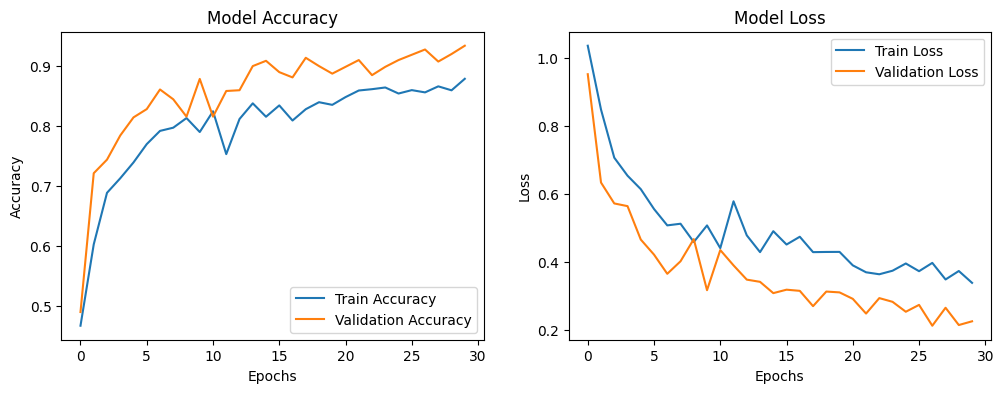

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


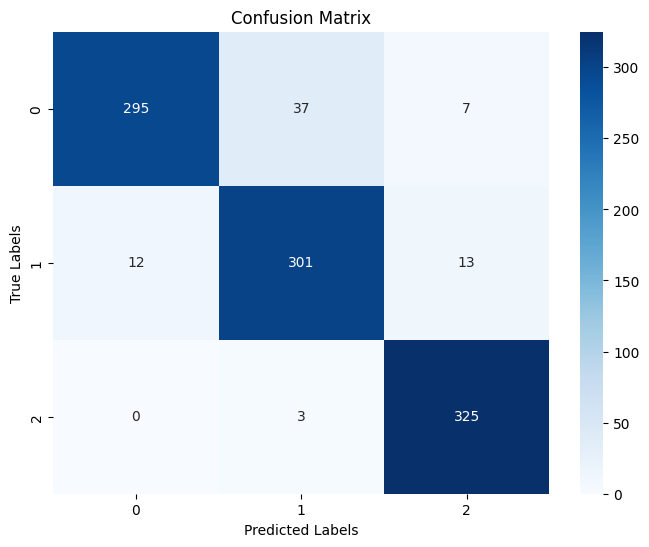

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes)
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       339
           1       0.88      0.92      0.90       326
           2       0.94      0.99      0.97       328

    accuracy                           0.93       993
   macro avg       0.93      0.93      0.93       993
weighted avg       0.93      0.93      0.93       993



# **LSTM Model 2**

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # Output 3 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 1, 128)              │          82,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,563 (1.35 MB)

 Trainable params: 354,563 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4092 - loss: 1.0748 - val_accuracy: 0.5686 - val_loss: 0.9297
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5706 - loss: 0.8938 - val_accuracy: 0.6918 - val_loss: 0.7044
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6662 - loss: 0.7724 - val_accuracy: 0.7698 - val_loss: 0.6026
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7079 - loss: 0.7057 - val_accuracy: 0.7157 - val_loss: 0.6483
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7014 - loss: 0.6970 - val_accuracy: 0.7887 - val_loss: 0.5187
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7482 - loss: 0.6379 - val_accuracy: 0.8075 - val_loss: 0.5492
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7368 - loss: 0.6326 - val_accuracy: 0.8113 - val_loss: 0.4753
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7829 - loss: 0.5371 - val_accuracy: 0

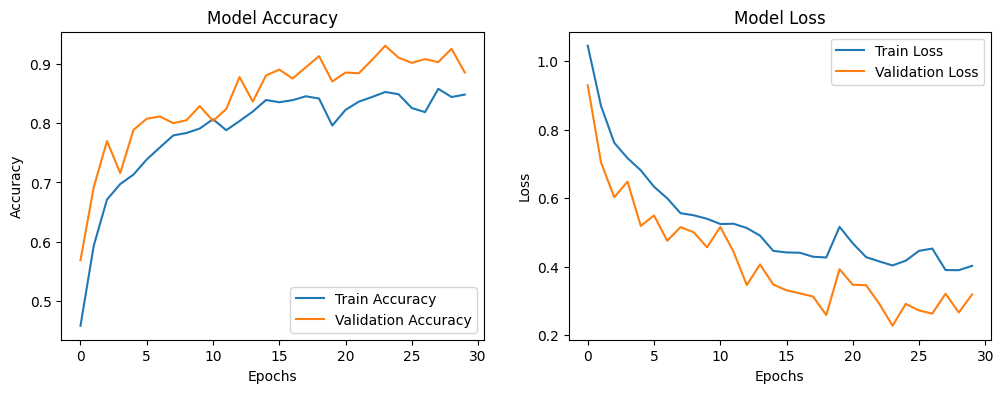

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


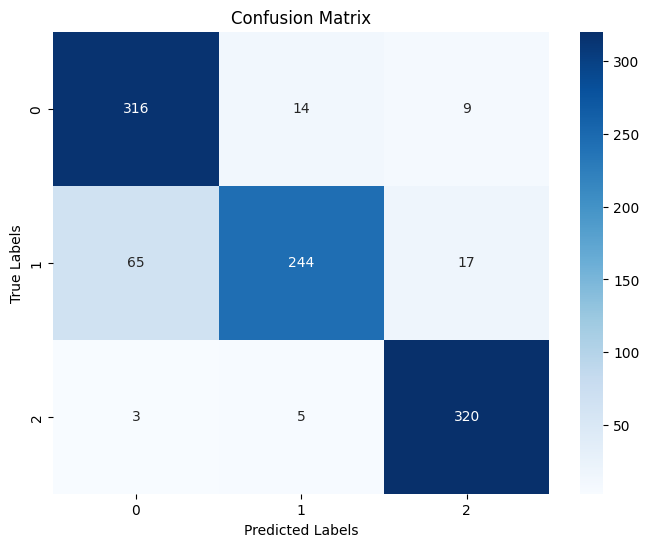

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes)
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       339
           1       0.93      0.75      0.83       326
           2       0.92      0.98      0.95       328

    accuracy                           0.89       993
   macro avg       0.89      0.89      0.88       993
weighted avg       0.89      0.89      0.88       993



# **Convolutional Neural Network**

In [ ]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[2], X_train.shape[1]))  # Shape: (3972, 33, 1)
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[2], X_test.shape[1])) # needs channel dimension

In [ ]:
X_train_cnn.shape

(3972, 33, 1)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(33, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 31, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 31, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 4, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 4, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,483 (392.51 KB)

 Trainable params: 99,843 (390.01 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7118 - loss: 0.6399 - val_accuracy: 0.5358 - val_loss: 1.2298
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9035 - loss: 0.2698 - val_accuracy: 0.6994 - val_loss: 0.7231
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9111 - loss: 0.2431 - val_accuracy: 0.8805 - val_loss: 0.3144
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9130 - loss: 0.2185 - val_accuracy: 0.9170 - val_loss: 0.2198
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9419 - loss: 0.1712 - val_accuracy: 0.7170 - val_loss: 0.9211
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9374 - loss: 0.1743 - val_accuracy: 0.8881 - val_loss: 0.2848
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9418 - loss: 0.1599 - val_accuracy: 0.9094 - val_loss: 0.2544
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9435 - loss: 0.1647 - val_accuracy:

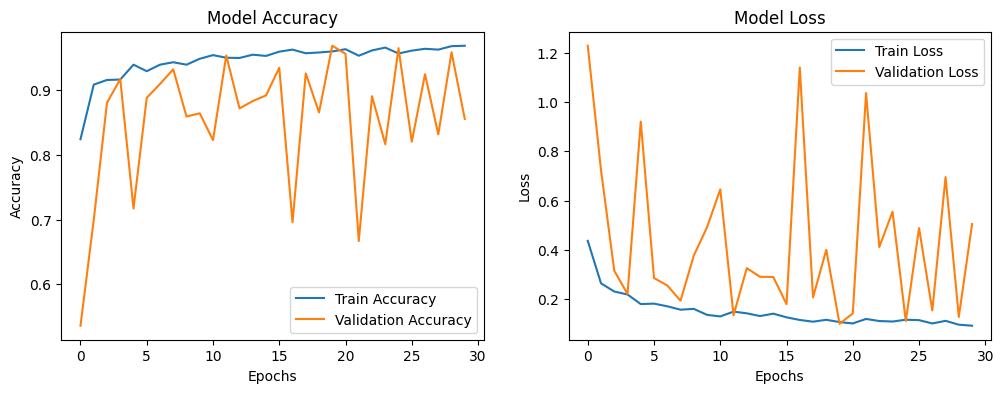

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


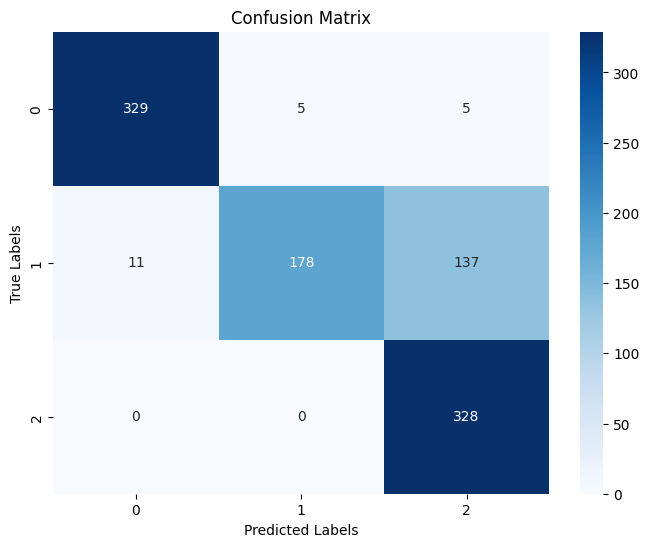

In [ ]:
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes)
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       339
           1       0.97      0.55      0.70       326
           2       0.70      1.00      0.82       328

    accuracy                           0.84       993
   macro avg       0.88      0.84      0.83       993
weighted avg       0.88      0.84      0.83       993



# **FNN**

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(1, 33)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,683 (61.26 KB)

 Trainable params: 15,235 (59.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4097 - loss: 1.2954 - val_accuracy: 0.4818 - val_loss: 0.9924
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5031 - loss: 1.0303 - val_accuracy: 0.5761 - val_loss: 0.8850
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6498 - loss: 0.7761 - val_accuracy: 0.7069 - val_loss: 0.6785
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7309 - loss: 0.6412 - val_accuracy: 0.7472 - val_loss: 0.6211
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7595 - loss: 0.5580 - val_accuracy: 0.7635 - val_loss: 0.5636
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7830 - loss: 0.5311 - val_accuracy: 0.8453 - val_loss: 0.3998
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.4890 - val_accuracy: 0.8428 - val_loss: 0.3699
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8135 - loss: 0.4615 - val_accuracy: 0

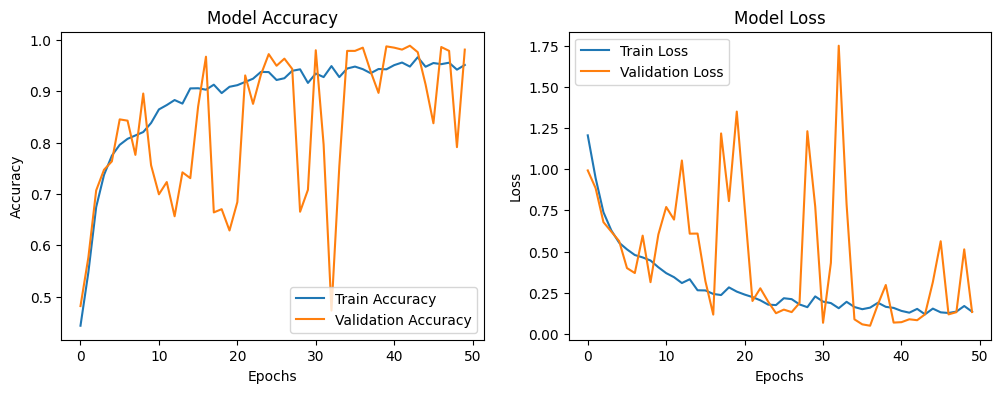

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


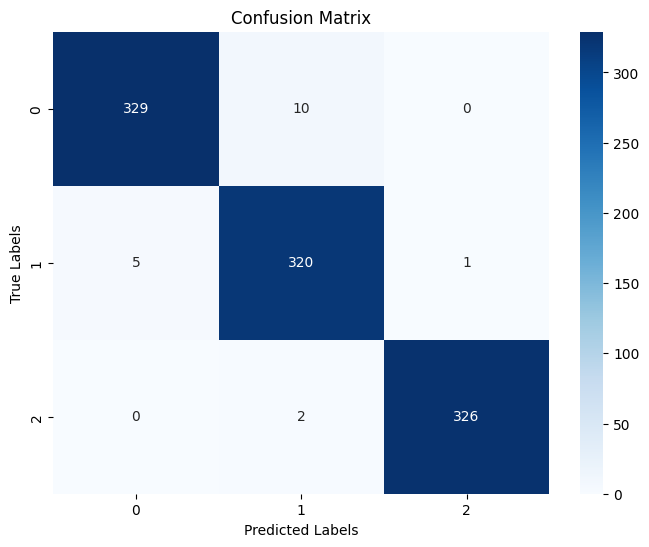

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes)
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.96      0.98      0.97       326
           2       1.00      0.99      1.00       328

    accuracy                           0.98       993
   macro avg       0.98      0.98      0.98       993
weighted avg       0.98      0.98      0.98       993

